In [1]:
import pandas as pd
import networkx as nx

In [2]:
PHILOSOPHY = "https://en.wikipedia.org/wiki/Philosophy"
NODE_TYPE_COLORS = {
    "seed": "green",
    "page": "blue",
    "error": "orange",
    "philosophy": "red",
}

In [3]:
edges = pd.read_csv(
    "../outputs/wiki_web.tsv",
    delimiter="\t",
    header=None,
    names=["source", "target"]
)

seeds = pd.read_table(
    "../outputs/seeds.txt",
    delimiter="\t",
    header=None,
    names=["url"]
).assign(node_type="seed")
node_types = pd.concat([
    seeds,
    pd.DataFrame([{"url": PHILOSOPHY, "node_type": "philosophy"}])
], ignore_index=True).set_index("url")["node_type"].to_dict()

for error_name in edges.target[edges.target.str.contains("ERROR")].values:
    node_types[error_name] = "error"


In [4]:
nodes = (
    pd.concat([pd.Series(PHILOSOPHY), edges.source, edges.target])
    .drop_duplicates(ignore_index=True)
    .to_frame("url")
    .assign(
        node_type = lambda df: df.url.map(node_types).fillna("page"),
        name = lambda df: df.url.str.split("/").str[-1]
    )
)
url_to_node_id = (
    nodes
    .reset_index()
    .set_index("url")
    ["index"]
    .to_dict()
)

seed_ids = nodes[nodes.node_type == "seed"].index.values.tolist()
error_ids = nodes[nodes.node_type == "error"].index.values.tolist()

edges["source_id"] = edges.source.map(url_to_node_id)
edges["target_id"] = edges.target.map(url_to_node_id)

In [34]:
print(nodes.node_type.rename("Node type").value_counts().rename("Count").to_markdown())

| Node type   |   Count |
|:------------|--------:|
| page        |    2413 |
| seed        |    1000 |
| error       |       3 |
| philosophy  |       1 |


In [5]:
G = nx.DiGraph()
G.add_nodes_from([(i,dict(d)) for i,d in nodes.iterrows()])
G.add_edges_from(edges[["source_id", "target_id"]].values.tolist())

In [6]:
shortest_path_lengths = list(nx.all_pairs_shortest_path_length(G))

In [25]:
def get_length_by_id(node_ids, node_dict):
    for id in node_ids:
        if id in node_dict:
            return (id, node_dict[id])
    return (None, None)

clicks_to_errors = [(n, *get_length_by_id(error_ids, l)) for n, l in shortest_path_lengths if n in seed_ids]
clicks_to_errors = (
    pd.DataFrame(clicks_to_errors, columns=["seed", "error", "clicks"])
    .merge(nodes.name, left_on="error", right_index=True, how="left")
    .rename(columns={"name": "Error"})
)

print(f"Seeds that lead to an error: {clicks_to_errors.clicks.notna().mean():.1%}")
print(f"Average # clicks: {clicks_to_errors.clicks.mean():.1f}")

res = (
    clicks_to_errors
    .groupby("Error")
    ["clicks"]
    .agg(
        **{
            "Number of seeds": "count",
            "Average clicks to error": "mean"   
        }
    )
    .assign(
        **{
            "% of seeds": lambda df: 100*df["Number of seeds"] / df["Number of seeds"].sum()
        }
    )
    .round(1)
    .sort_values("Number of seeds", ascending=False)
).to_markdown()
print(res)

Seeds that lead to an error: 0.7%
Average # clicks: 2.3
| Error                                |   Number of seeds |   Average clicks to error |   % of seeds |
|:-------------------------------------|------------------:|--------------------------:|-------------:|
| ERROR: Unmatched open parentheses.   |                 4 |                       2.8 |         57.1 |
| ERROR: Unmatched closed parentheses. |                 2 |                       2   |         28.6 |
| ERROR: No valid link found.          |                 1 |                       1   |         14.3 |


Seeds that lead to Philosophy: 43.9%
Average # clicks: 13.4


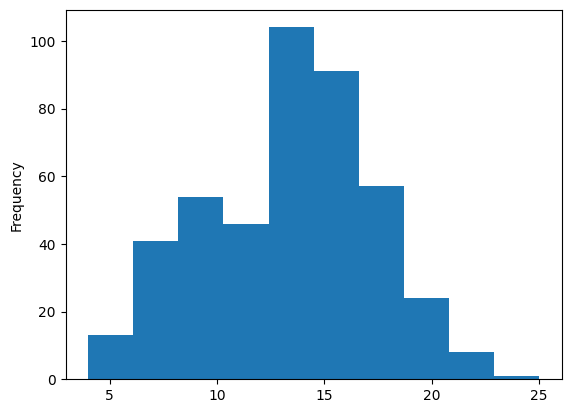

In [18]:
clicks_to_philosphy = {n: l.get(0) for n, l in shortest_path_lengths if n in seed_ids}
clicks_to_philosphy = pd.Series(clicks_to_philosphy, name="clicks_to_philosophy")

clicks_to_philosphy.plot.hist()
print(f"Seeds that lead to Philosophy: {clicks_to_philosphy.notna().mean():.1%}")
print(f"Average # clicks: {clicks_to_philosphy.mean():.1f}")

In [9]:
for philosophy_cycle in nx.simple_cycles(G):
    if 0 in philosophy_cycle:
        philosophy_cycle
        break

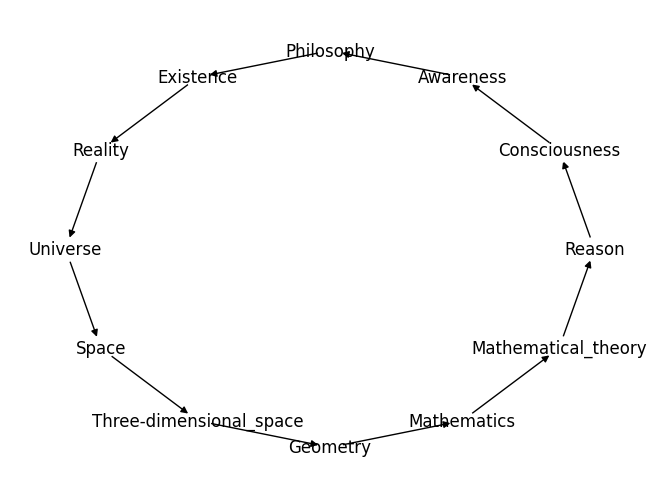

In [10]:
sg = nx.subgraph_view(G, filter_node=lambda n: n in philosophy_cycle)

pos = nx.circular_layout(sg)
# Rotate -90
pos = {k: (-y,x) for k,(x,y) in pos.items()}

nx.draw(
    sg,
    pos=pos,
    node_color="white",
    labels={node: sg.nodes[node]["name"] for node in sg.nodes},
    with_labels=True,
)

In [24]:

clicks_to_philosphy_cycle = {}
for node_id, path_lengths in shortest_path_lengths:
    if node_id not in seed_ids:
        continue
    
    min_distance = float("Inf")
    entry_node_id = None
    for cycle_node_id, cycle_path_length in path_lengths.items():
        if cycle_node_id not in philosophy_cycle:
            continue
        if cycle_path_length < min_distance:
            min_distance = cycle_path_length
            entry_node_id = cycle_node_id
        clicks_to_philosphy_cycle[node_id] = {"entry": entry_node_id, "distance": min_distance}
clicks_to_philosphy_cycle = (
    pd.DataFrame.from_dict(clicks_to_philosphy_cycle, orient="index")
    .assign(entry = lambda df: df.entry.map(nodes.url.to_dict()))
)

res = (
    clicks_to_philosphy_cycle
    .rename(columns={"entry": "Entry to the Philosophy cycle"})
    .groupby("Entry to the Philosophy cycle")
    ["distance"]
    .agg(
        **{
            "Number of seeds": "count",
            "Average clicks to entry": "mean"   
        }
    )
    .assign(
        **{
            "% of seeds": lambda df: 100*df["Number of seeds"] / df["Number of seeds"].sum()
        }
    )
    .round(1)
    .sort_values("Number of seeds", ascending=False)
).to_markdown()
print(res)

| Entry to the Philosophy cycle             |   Number of seeds |   Average clicks to entry |   % of seeds |
|:------------------------------------------|------------------:|--------------------------:|-------------:|
| https://en.wikipedia.org/wiki/Philosophy  |               319 |                      13.6 |         72.7 |
| https://en.wikipedia.org/wiki/Mathematics |                31 |                       8.2 |          7.1 |
| https://en.wikipedia.org/wiki/Reason      |                26 |                       7.8 |          5.9 |
| https://en.wikipedia.org/wiki/Awareness   |                22 |                       7.5 |          5   |
| https://en.wikipedia.org/wiki/Reality     |                18 |                       5.4 |          4.1 |
| https://en.wikipedia.org/wiki/Existence   |                17 |                       8.4 |          3.9 |
| https://en.wikipedia.org/wiki/Geometry    |                 6 |                       7   |          1.4 |
